# **Deep Learning Homework 6: *Variational Autoencoders***
---

In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset. In developing the VAE we also explore how to develop an ad-hoc layer and a custom training step.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime type* at the bottom of the page, and then select the GPU hardware accelerator.


### Load Dataset
We load the MNIST dataset, using `tf.keras.datasets`. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits.

In [2]:
# load necessary libraries and functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch,history.history['reconstruction_loss'])
  plt.title('reconstruction_loss')
  plt.subplot(1, 2, 2)
  plt.plot(history.epoch,history.history['kl_loss'])
  plt.title('kl_loss')
  plt.show()

In [3]:
(x_train_full, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the pixel values
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the arrays
x_train = x_train_full.reshape((len(x_train_full), np.prod(x_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# In this HW, we will not need a validation set since we will not deal with model selection
# x_valid, y_valid = x_train[:10000], y_train[:10000]
# x_train, y_train = x_train[10000:], y_train[10000:]

11501568/11490434 [==============================] - 0s 0us/step


## Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class `tf.keras.layers` that is used as base class for all the layers defined in Keras. In more detail, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.



In [5]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        # compute and return z
        z_mean, z_var = inputs        
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

## Exercise 6.2: Encoder
Now we can define the Encoder. Let's use $n$ dense layers (similarly to what we did in HW5, with a funnel-like architecture), and then use the obtained encoding to compute `z_mean` and `z_var`, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.

In [6]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]
n=2
max_num_units = 500 # parameter we'll use to control the maximum number of units per layer
k = (max_num_units-latent_dim)/n # parameter we'll use to give the network an hourglass structure
# the first hidden layer will have a number of units equal to: max_num_units-np.floor(k)

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
x = encoder_inputs
for i in range(n-1):
  x = tf.keras.layers.Dense(max_num_units-np.floor((i+1)*k), activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation=None)(x) # size would be = latent_dim
z_var =  tf.keras.layers.Dense(latent_dim, activation=None)(x) # size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 251)          197035      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            504         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            504         ['dense[0][0]']                  
                                                                                            

The model we chose for the encoder consists of a single hidden layer before the two separate dense layers dedicated to the mean and log variance calculations (and of course the sampling layer immediately after).\
The reason for this choice is that by experimenting with various numbers of layers and layer sizes, it turned out that the more layers there are, the worse the latent representation of the training set and consequently the generation of new samples.\
For a large number of layers and neurons, we observed a very oscillating behavior in the two loss functions used: reconstruction loss and KL divergence.
This phenomenon is still present with fewer layers and units, although in a much weaker way, as we will see later in the notebook.\
As for the activation functions, for the first hidden layer we decided to use relu, while for the dense layers related to mean and log_var we decided not to use any activation functions, to avoid possible constraints on their values.\
We also experimented with other activation functions on the first hidden layer, namely: identity (no activation) and tanh.\
Interestingly, in the various models we tried, not using any activation function gave the worst results, leading to a messy latent representation of the training set, in which the classes were all mixed together in the same region.\
For tanh, on the other hand, the latent space representation provided by the model grouped the points along strange yet very structured shapes, shapes that one would not expect from normally distributed points, so we discarded it.\
We noticed, however, that despite these strange shapes, tanh was able to separate classes quite well in the latent representation, although this strongly depended on the size of the batch we used.

## Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder will be specular to the encoder architecture, i.e. $n$ layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = latent_inputs

for i in range(n-1):
  x = tf.keras.layers.Dense(latent_dim+np.ceil((i+1)*k), activation='relu')(x)

decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 251)               753       
                                                                 
 dense_6 (Dense)             (None, 784)               197568    
                                                                 
Total params: 198,321
Trainable params: 198,321
Non-trainable params: 0
_________________________________________________________________


The number of layers and the size of the layers are dictated by the mirror structure required by the assignment.\
In the decoding layers we used sigmoid as the activation function.\
This makes perfect sense, since we are trying to reproduce images from the original x_train dataset, and at the beginning of the notebook we have scaled each of these images so that the pixel values are within the range $[0,\;1]$.

## Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy (`keras.losses.binary_crossentropy`) to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):        
        if isinstance(data, tuple):
            data = data[0]        
        with tf.GradientTape() as tape: # record operations for automatic differentiation
            z_mean, z_var, z = encoder(data)            
            reconstruction = decoder(z)                                
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction, from_logits=False)))
            
            # closed form expression for KL-Divergence when both distributions are Gaussian. In our case we have: N(z_mean, exp(z_var)) and N(0, 1)           
            kl_loss = -0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # what this loss does is to force q(z|x) to become similar to a distribution N(0, 1), where q(z|x) is the 'encoder distribution'.
            # In this sense, we're forcing the dataset to be represented by a Standard Normal distribution.
            # This comes very handy in practice since sampling from a N(0, 1) is simpler w.r.t. other distributions
            # and allows us to easily generate new samples.

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # optimize the custom loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

Epoch 1/10
509/509 [==============================] - 5s 4ms/step - loss: 33.4886 - reconstruction_loss: 31.1012 - kl_loss: 2.3874
Epoch 2/10
509/509 [==============================] - 2s 4ms/step - loss: 28.5681 - reconstruction_loss: 26.7191 - kl_loss: 1.8491
Epoch 3/10
509/509 [==============================] - 2s 4ms/step - loss: 28.1778 - reconstruction_loss: 26.1081 - kl_loss: 2.0698
Epoch 4/10
509/509 [==============================] - 2s 4ms/step - loss: 27.9486 - reconstruction_loss: 25.7325 - kl_loss: 2.2161
Epoch 5/10
509/509 [==============================] - 2s 5ms/step - loss: 27.7867 - reconstruction_loss: 25.4980 - kl_loss: 2.2887
Epoch 6/10
509/509 [==============================] - 2s 4ms/step - loss: 27.6783 - reconstruction_loss: 25.3302 - kl_loss: 2.3482
Epoch 7/10
509/509 [==============================] - 2s 4ms/step - loss: 27.5817 - reconstruction_loss: 25.1732 - kl_loss: 2.4086
Epoch 8/10
509/509 [==============================] - 2s 4ms/step - loss: 27.4858 -

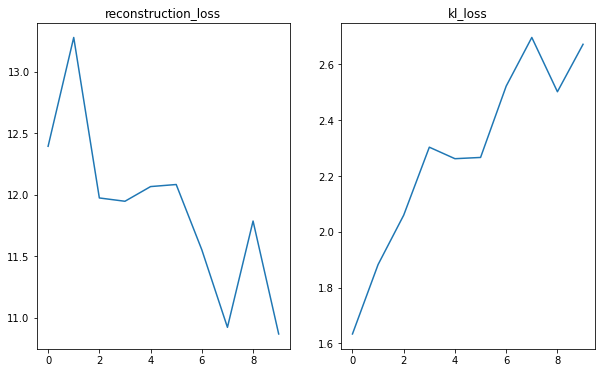

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=10, batch_size=118)
plot_loss(history)

## Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

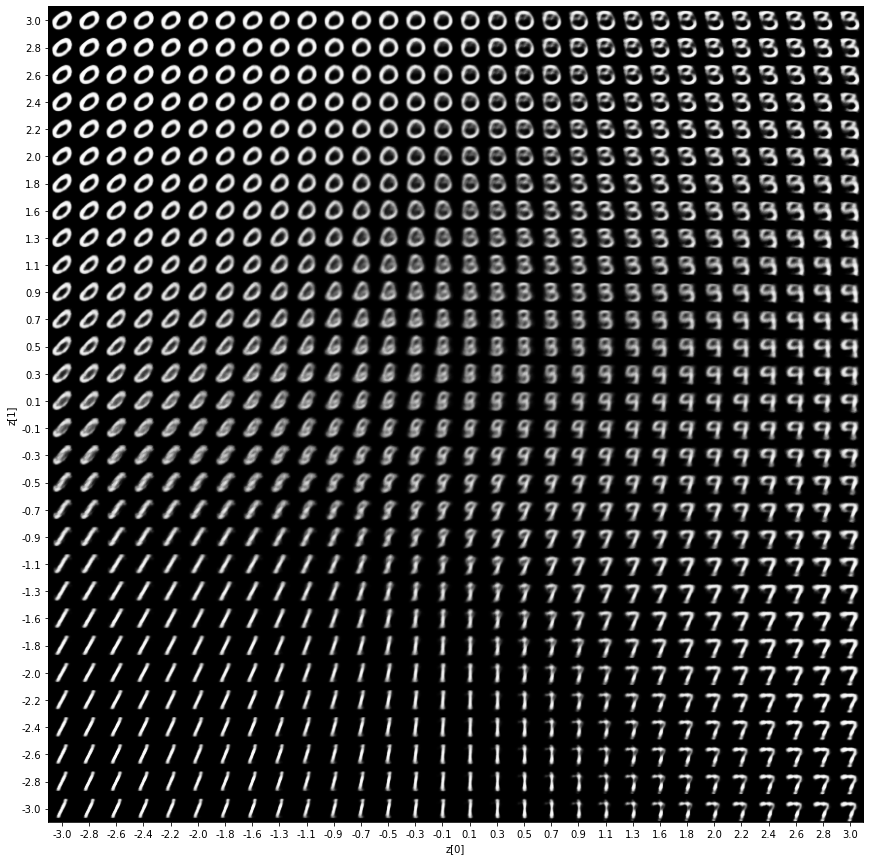

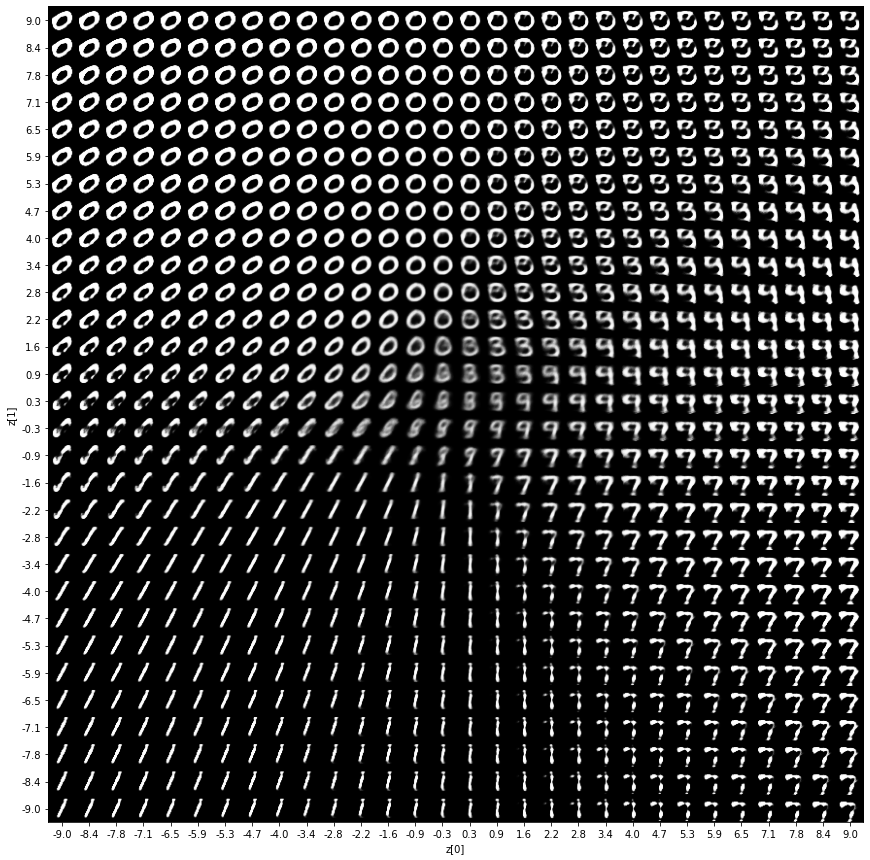

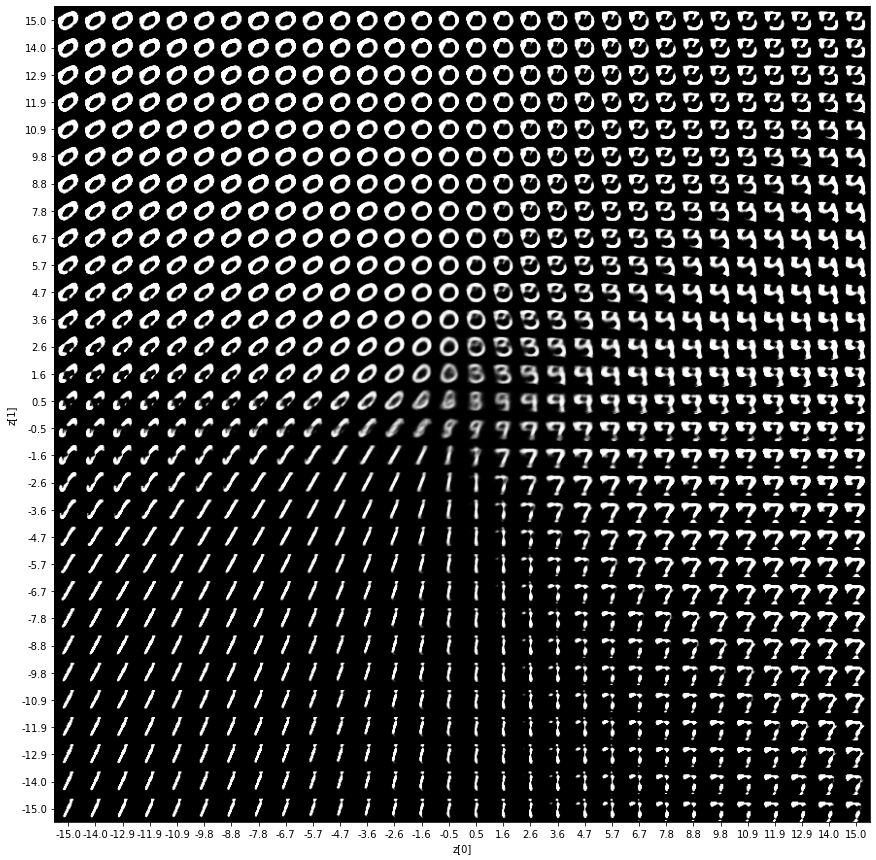

In [12]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 3.0, 30)
plot_latent(encoder, decoder, 9.0, 30) 
plot_latent(encoder, decoder, 15.0, 30)

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

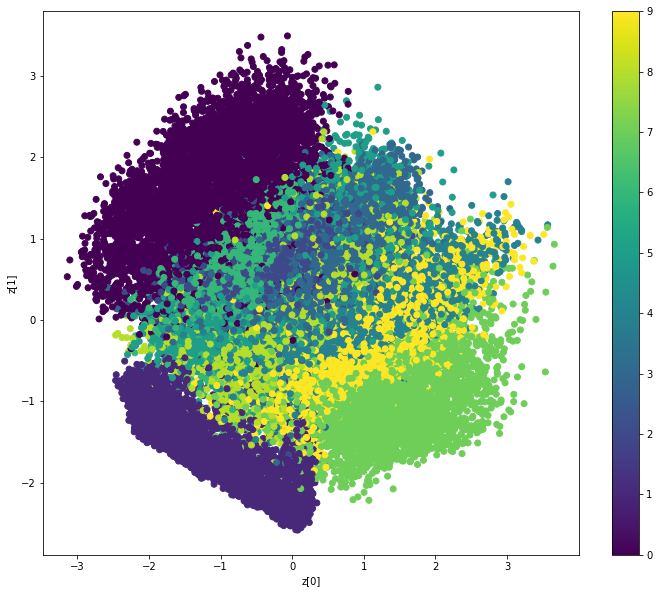

In [13]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

The first thing to note is that despite the very erratic behavior of the losses, the model actually performed quite well. As discussed earlier, an increasing number of layers and units leads to equally or even more erratic behavior than the ones obtained.\
We decided to stop the fitting after 10 epochs, since the losses seemed to stabilize fairly quickly and start oscillating around the same thresholds after a few iterations.\
A key role here is played by the batch size parameter, the modification of which produced dramatically different results for all the models we tested.\
In particular, smaller batches were able to provide smaller losses, especially for the KL-Divergence. With batches of about 30, the KL-loss reached values of about $10^{-9}$.\
Interestingly, very small values of KL-loss seem to produce the worst results, leading to disordered latent representations in which all classes are mixed together.\
Furthermore, as noted earlier, the batch size was particularly important for the tanh activation function: small values yielded performances almost comparable to relu, while larger values yielded the strange shapes discussed earlier.\
From the latent space representation plotted above, we can see that the model has learned to distinguish some classes better than others.\
For example, classes 0, 1 and 7 have a very definite latent representation, so we expect the model to generate clearer samples of these classes.\
In contrast, we expect that the model will not be able to correctly generate samples of the classes mixed in the middle, such as 3, 8 and 9.\
All these considerations are also validated by the sample generations plotted above.\
In particular, in the three different images we plotted, we can see that the "numbers" in the central region are always blurred and not well defined, for the reasons we just discussed.\
We also noticed that the more we increase the scale, the less the generated samples represent actual numbers.\
Again, this is not surprising, since the KL-Div pushes the training set to be represented by an N(0, 1) distribution, and the reconstruction loss then teaches the model how to generate samples from such distribution.\
We know that for a Gaussian distribution, about 99.7% of the observed data are approximately within 3 standard deviations of the mean; in this sense, values far away from this region are problematic for the model, since it has not learned how to properly generate new samples from these values.\
To conclude, let us also take a look at a convolutional VAE to see if we can get better results.

# Convolutional Variational Autoencoder

Just out of curiosity, let's also experiment with a convolutional VAE.\
We'll try to keep the mirror structure previously required, and we will also keep the sigmoid activation function on the decoding layer.\
Again, this makes perfect sense, since each image in the training set is rescaled so that each pixel takes values in the range $[0,\;1]$.

## Encoder

In [ ]:
from tensorflow.keras import layers

latent_dim = 2
INPUT_DIM = x_train.shape[-1]
n=2

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))

# we reshape the vectors into the original 28x28 images
x = layers.Reshape((28, 28, 1))(encoder_inputs)


for i in range(n):
  x = layers.Conv2D(46, (2, 2), strides=1, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2))(x)

# dimensions of the current image (needed for the hourglass structure)
dim1 = x.shape[1:]
x = layers.Flatten()(x)
# dimensions of the flattended image (needed for the hourglass structure)
dim2 = x.shape[1]
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 28, 28, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 46)   230         ['reshape[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 46)   0           ['conv2d[0][0]']                 
                                                                                            

## Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(dim2, activation="relu")(latent_inputs)
x = layers.Reshape(dim1)(x)

for i in range(n):  
  x = layers.Conv2DTranspose(16, (2, 2), strides=2, activation="relu", padding="valid")(x)
#x = layers.Conv2D(1, (3, 3), activation="sigmoid", strides=1, padding="same")(x)
x = layers.Flatten()(x)
decoder_outputs = layers.Dense(INPUT_DIM, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2254)              6762      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 46)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 16)       2960      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1040      
 ranspose)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0   

# Fitting the model

Epoch 1/5
469/469 [==============================] - 165s 345ms/step - loss: 33.1543 - reconstruction_loss: 32.0362 - kl_loss: 1.1181
Epoch 2/5
469/469 [==============================] - 161s 343ms/step - loss: 30.3497 - reconstruction_loss: 28.0732 - kl_loss: 2.2765
Epoch 3/5
469/469 [==============================] - 162s 346ms/step - loss: 29.9350 - reconstruction_loss: 27.3841 - kl_loss: 2.5510
Epoch 4/5
469/469 [==============================] - 161s 343ms/step - loss: 29.6958 - reconstruction_loss: 26.9754 - kl_loss: 2.7204
Epoch 5/5
469/469 [==============================] - 162s 345ms/step - loss: 29.5270 - reconstruction_loss: 26.6880 - kl_loss: 2.8389


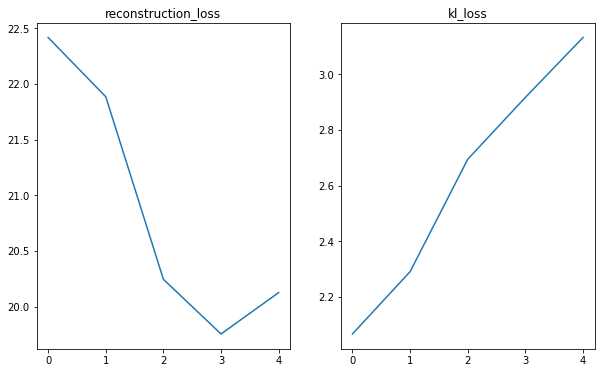

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=5, batch_size=128)
plot_loss(history)

As we expected, model fitting is considerably slower w.r.t. the previous model, for this reason we stopped the process after just 5 epochs.\
Of course we expect this decision to influence the final results.

Let's generate some samples.

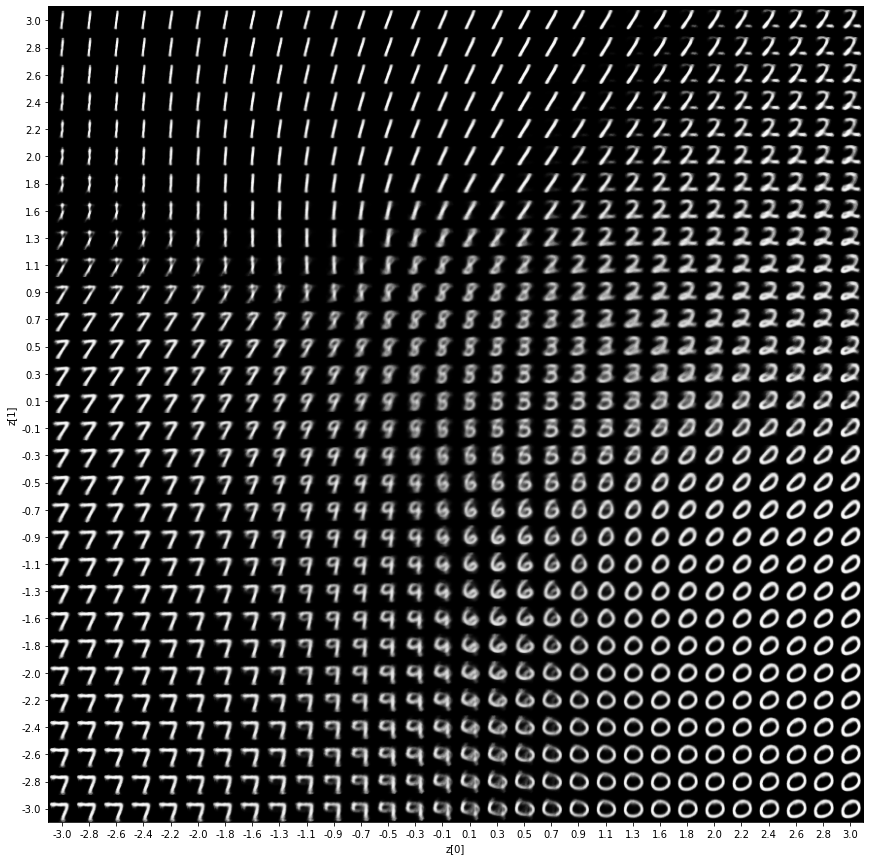

In [ ]:
plot_latent(encoder, decoder, 3.0, 30) 

Let's also plot the latent space representation of the input.

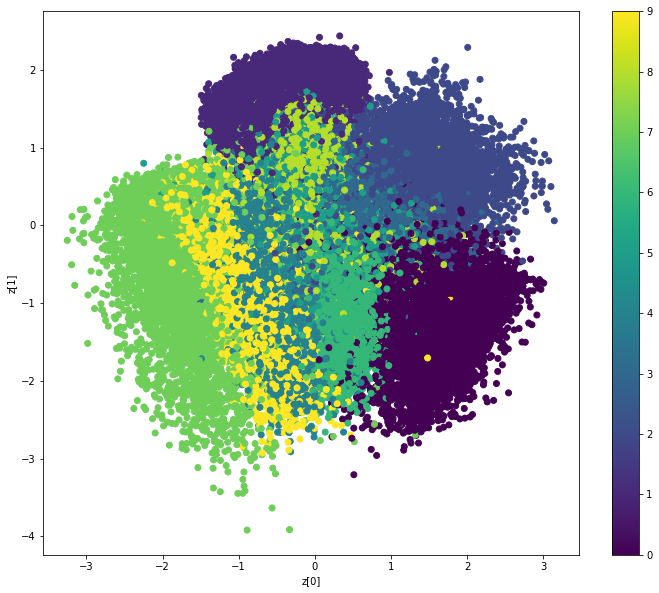

In [ ]:
plot_label_clusters(encoder, decoder, x_train, y_train)

The simple convolutional VAE we built seems to better represent more classes than the previous one, although, surprisingly, even this model has problems handling classes such as 3, 8, and 9, as can be seen by the disordered region in the center.\
Perhaps a deeper model could solve this problem, however this is something we won't try since adding layers makes it difficult to maintain the hourglass structure and test times increase significantly.